In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error


np.random.seed(0)

In [35]:
df = pd.read_csv("./datasets/wdbc.data", header=None).drop(columns=[0])
df_benign = df[df[1] == 'B'].drop(columns=[1])

col_names = [
    "radius",
    "texture",
    "perimeter",
    "area",
    "smoothness",
    "compactness",
    "concavity",
    "concave",
    "symmetry",
    "fractal"
]
columns = list(range(2, 12))
columns_dict = dict(zip(columns, col_names))

df_benign = df_benign[columns].rename(columns=columns_dict)

In [36]:
df_benign

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave,symmetry,fractal
19,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.047810,0.1885,0.05766
20,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.031100,0.1967,0.06811
21,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.020760,0.1815,0.06905
37,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.029230,0.1467,0.05863
46,8.196,16.84,51.71,201.9,0.08600,0.05943,0.01588,0.005917,0.1769,0.06503
...,...,...,...,...,...,...,...,...,...,...
558,14.590,22.68,96.39,657.1,0.08473,0.13300,0.10290,0.037360,0.1454,0.06147
559,11.510,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.041050,0.1388,0.06570
560,14.050,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.043040,0.1537,0.06171
561,11.200,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.000000,0.1060,0.05502


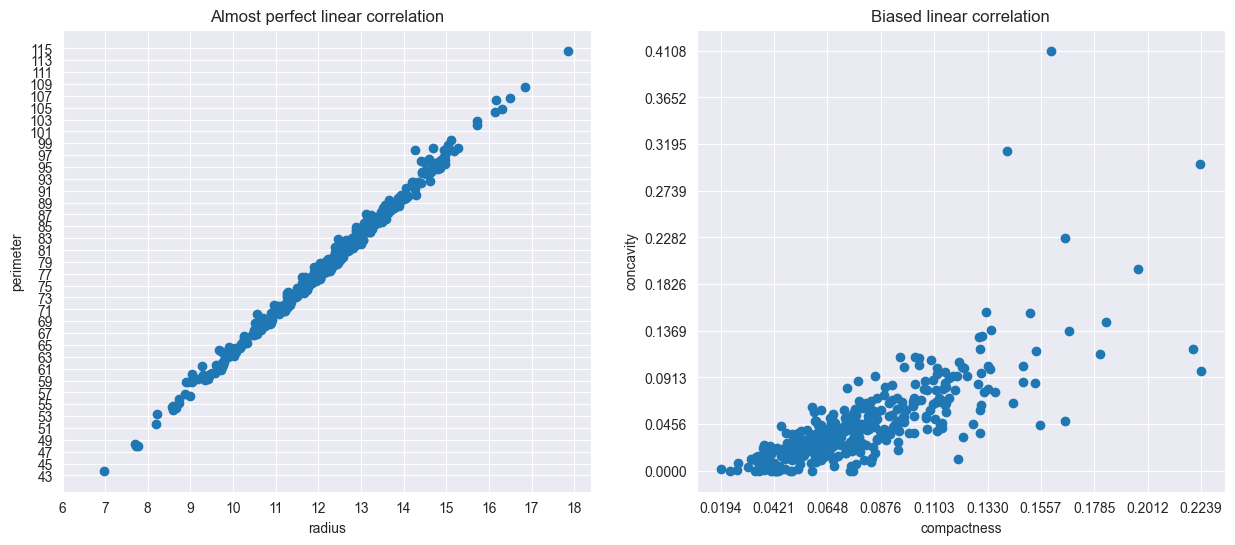

In [37]:
perfect_linear_corr_set = ['radius', 'perimeter']
biased_linear_corr_set = ['compactness', 'concavity']

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

df_linear = df_benign[perfect_linear_corr_set].sort_values(by=perfect_linear_corr_set[0]).reset_index(drop=True)
df_biased_linear = df_benign[biased_linear_corr_set].sort_values(by=biased_linear_corr_set[0]).reset_index(drop=True)

def display_linear(ax, ax_i, df_linear):
    ax[ax_i].scatter(df_linear.values[:, 0], df_linear.values[:, 1])
    ax[ax_i].set_title("Almost perfect linear correlation")
    ax[ax_i].set_xlabel(perfect_linear_corr_set[0])
    ax[ax_i].set_ylabel(perfect_linear_corr_set[1])
    x_min, x_max = df_linear.values[:, 0].min(), df_linear.values[:, 0].max()
    y_min, y_max = df_linear.values[:, 1].min(), df_linear.values[:, 1].max()
    ax[ax_i].set_xticks(np.arange(np.floor(x_min), np.ceil(x_max) + 1, 1))
    ax[ax_i].set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + 1, 2))

def display_biased_linear(ax, ax_i, df_biased_linear):
    ax[ax_i].scatter(df_biased_linear.values[:, 0], df_biased_linear.values[:, 1])
    ax[ax_i].set_title("Biased linear correlation")
    ax[ax_i].set_xlabel(biased_linear_corr_set[0])
    ax[ax_i].set_ylabel(biased_linear_corr_set[1])
    x_min, x_max = df_biased_linear.values[:, 0].min(), df_biased_linear.values[:, 0].max()
    y_min, y_max = df_biased_linear.values[:, 1].min(), df_biased_linear.values[:, 1].max()
    ax[ax_i].set_xticks(np.linspace(x_min, x_max, num=10))
    ax[ax_i].set_yticks(np.linspace(y_min, y_max, num=10))

display_linear(ax, 0, df_linear)
display_biased_linear(ax, 1, df_biased_linear)


In [38]:
def build_and_analyze_model(df, x_col, y_col, biased=False, outlier_threshold=3):
    X = sm.add_constant(df[x_col])
    y = df[y_col]

    model = sm.OLS(y, X)
    model_results = model.fit()

    print(f"\n\n{"="*10} Correlation: {"="*10}")
    correlation_value = df[x_col].corr(df[y_col], method='pearson')  # ((x - x.mean()) * (y - y.mean())).mean() / (x.std() * y.std())
    print(f'Pearson correlation coefficient between `{x_col}` and `{y_col}`: {correlation_value}')
    print("="*60)
    
    print(f"\n\n{"="*10} Model summary description: {"="*10}")
    print(model_results.summary())
    print("="*60)
    
    residuals = model_results.resid
    fitted_values = model_results.fittedvalues


    print(f"\n\n{"="*10} Residuals squared error: {"="*10}")
    rse = np.mean(residuals ** 2)
    print(f'RSE: {rse}')
    print("="*60)

    print(f"\n\n{"="*10} Residuals statistics description: {"="*10}")
    display(residuals.describe())
    print("="*60)

    fig, ax = plt.subplots(3, 3, figsize=(18, 18))
    ax = ax.flatten()

    if biased:
        display_biased_linear(ax, 0, df)
    else:
        display_linear(ax, 0, df)
    xs = np.linspace(df[x_col].min(), df[x_col].max(), 2)
    ys = model_results.params[x_col] * xs + model_results.params['const']
    ax[0].plot(xs, ys, color='red')
    ax[0].set_title("Regression line")

    sns.histplot(residuals, kde=True, ax=ax[1])
    ax[1].set_title('Histogram residuals')
    
    scipy.stats.probplot(residuals, dist="norm", plot=ax[2])
    ax[2].set_title('Q-Q plot residuals')

    ax[3].scatter(fitted_values, residuals, edgecolors='k', facecolors='none')
    ax[3].axhline(0, color='gray', linestyle='dashed', linewidth=2)
    ax[3].set_title("Residuals vs fitted")
    ax[3].set_xlabel("Fitted values")
    ax[3].set_ylabel("Residuals")
    z = sm.nonparametric.lowess(residuals, fitted_values)
    ax[3].plot(z[:, 0], z[:, 1], color='red', lw=2)


    sqrt_standardized_residuals = np.sqrt(np.abs(residuals / np.std(residuals)))
    ax[4].scatter(fitted_values, sqrt_standardized_residuals, edgecolors='k', facecolors='none')
    z = sm.nonparametric.lowess(sqrt_standardized_residuals, fitted_values)
    ax[4].plot(z[:, 0], z[:, 1], color='red', lw=2)
    ax[4].set_title("Scale-location")
    ax[4].set_xlabel("Fitted values")
    ax[4].set_ylabel("√|Standardized residuals|")


    cooks_d = model_results.get_influence().cooks_distance[0]
    outlier_cooks_threshold = (4 / (cooks_d.size - 1))
    outliers_cooks_d = np.where(cooks_d > outlier_cooks_threshold)[0]
    ax[5].plot(cooks_d, 'bo', linestyle='None')
    ax[5].axhline(outlier_cooks_threshold, color='red', linestyle='dashed', label=f"Threshold: {outlier_cooks_threshold}")
    ax[5].set_title("Cook's Distance")
    ax[5].set_xlabel("Observation Index")
    ax[5].set_ylabel("Cook's Distance")

    standardized_residuals = np.abs(residuals / np.std(residuals))
    ax[6].boxplot(standardized_residuals)
    ax[6].set_title('Boxplot of Standardized Residuals')
    ax[6].set_ylabel('Standardized Residuals')

    # Wartości odstające i wpływowe
    sm.graphics.influence_plot(model_results, criterion="cooks", ax=ax[7])

    
    
    
    print(f"\n\n{"="*10} Residual normality check: {"="*10}")
    print("Shapiro-Wilk test p-value:", scipy.stats.shapiro(residuals)[1])
    print("="*60)

    print(f"\n\n{"="*10} Residual skewness check: {"="*10}")
    print("Skewness:", pd.Series(residuals).skew())
    print("="*60)

    print(f"\n\n{"="*10} Residual kurtosis check: {"="*10}")
    print("Kurtosis:", pd.Series(residuals).kurtosis())
    print("="*60)

    
    # Homoskedastyczność (test Levene'a)
    print(f"\n\n{"="*10} Homoscedasticity check: {"="*10}")
    median = np.median(fitted_values)
    group1 = residuals[fitted_values <= median]
    group2 = residuals[fitted_values > median]
    levene_test = scipy.stats.levene(group1, group2)
    print("Levene's test p-value:", levene_test.pvalue)
    print("="*60)

    # Test Box-Pierce
    print(f"\n\n{"="*10} Autocorrelation check (for lags=1,2,3): {"="*10}")
    boxpierce_results = sm.stats.diagnostic.acorr_ljungbox(residuals, lags=3, boxpierce=True)
    display(boxpierce_results)
    print("Box-Pierce test statistic:", boxpierce_results['bp_stat'].values)
    print("Box-Pierce test p-value:", boxpierce_results['bp_pvalue'].values)
    print("="*60)


    print(f"\n\n{"="*10} Outliers list: {"="*10}")
    print(f"\nIndices of outliers based on cooks distance (beyond threshold {outlier_cooks_threshold}): {outliers_cooks_d}")
    print("="*60)

    print(f"\n\n{"="*10} Correlation coefficient statistical significance: {"="*10}")
    r2 = model_results.rsquared
    stat = r2 / np.sqrt((1 - r2) / (df.shape[0]-2))
    crit = scipy.stats.t.ppf(1 - 0.05/2, df.shape[0]-2)
    print(f"Statystyka t: {stat} \nWartość krytyczna (górna): {crit}")
    print("="*60)

    plt.legend()
    plt.show()

    return outliers_cooks_d

<center>
<h4>
Badanie liniowej zależnosci miedzy `radius` a `perimeter`
</h4>
</center>

Wiemy, że zależność miedzy promieniem a obwodem jest liniowa z wzoru 2PIr. Oczekujemy prawie perfekcyjnej liniowej zależności, która będzie 
zaburzona najprawdopodobnije błędami pomiaru. Promień może być jedynie dodatni oraz jego wielkość również nie moze przekraczać, powiedzmy 40cm.

In [39]:
df_linear = df_linear[(df_linear.radius > 0) & (df_linear.radius < 40)]



========== Correlation: ==========
Pearson correlation coefficient between `radius` and `perimeter`: 0.9967687954493821


========== Model summary description: ==========
                            OLS Regression Results                            
Dep. Variable:              perimeter   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 5.467e+04
Date:                Sun, 26 May 2024   Prob (F-statistic):               0.00
Time:                        22:15:02   Log-Likelihood:                -487.16
No. Observations:                 357   AIC:                             978.3
Df Residuals:                     355   BIC:                             986.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err     

count    3.570000e+02
mean     3.524849e-14
std      9.484223e-01
min     -1.943908e+00
25%     -6.555638e-01
50%     -1.751847e-01
75%      4.983433e-01
max      5.784394e+00
dtype: float64



========== Residual normality check: ==========
Shapiro-Wilk test p-value: 3.727549911804736e-12


========== Residual skewness check: ==========
Skewness: 1.3225605695852471


========== Residual kurtosis check: ==========
Kurtosis: 3.9253339011558235


========== Homoscedasticity check: ==========
Levene's test p-value: 0.013844399760259179


========== Autocorrelation check (for lags=1,2,3): ==========


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2.979857,0.084307,2.954956,0.085615
2,3.483489,0.175214,3.452976,0.177908
3,5.335377,0.148823,5.279072,0.152466


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Box-Pierce test statistic: [2.95495558 3.45297611 5.27907215]
Box-Pierce test p-value: [0.08561466 0.17790812 0.15246615]


========== Outliers list: ==========

Indices of outliers based on cooks distance (beyond threshold 0.011235955056179775): [  3   5  14  15  17  18  20  33  36  67 200 252 313 315 318 321 326 327
 331 345 346 352 356]


========== Correlation coefficient statistical significance: ==========
Statystyka t: 233.05419642538163 
Wartość krytyczna (górna): 1.9666688922770992


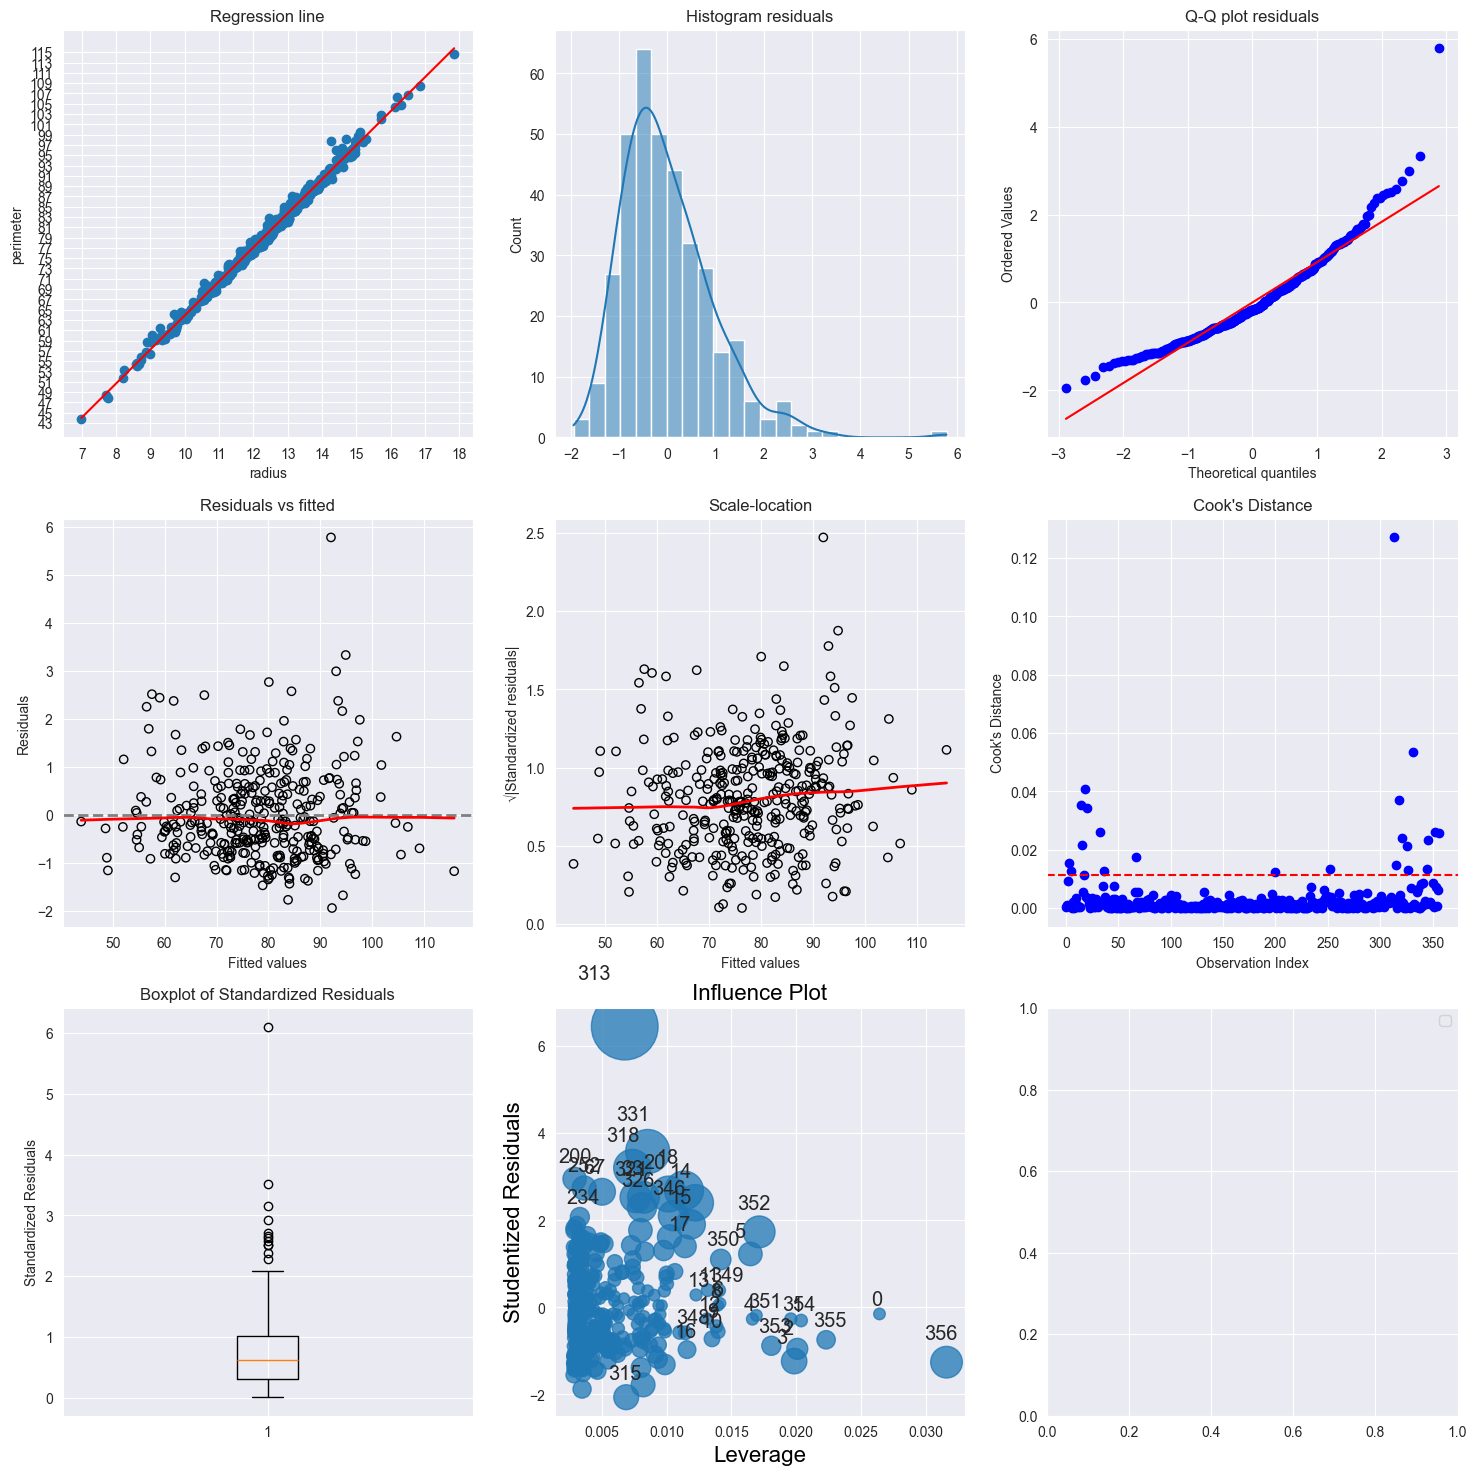

In [40]:
outliers = build_and_analyze_model(df_linear, 'radius', 'perimeter')

- Korelacja wynosi 0.99 co świadczy o bardzo wysokiej zależności między tymi dwoma zmiennymi. Dopasowany model ma postać funkcyjną \
y = 6.61 * x + -2.21 \
i został dopasowany na 357 obserwacjach. 
- Wartości reziduów mają rozkład normalny, prawoskośny. O normalności świadczy test saphiro-wilka,
którego p-value < 0.05 (qq-plot wykazuje minimalne odchylenie od normalności, ponieważ nie wsyzskite wartości leżą ideealnie na linii.)
- Dodatnie Skewness (1.32) wskazuje na prawostronną skośność, co widoczne jest też na histogramie - sporo predykcji dla których otrzymujemy zbyt duze wartości. Kurtoza ma wartość 4 co oznaczałoby
grube ogony w rozkladzie reziduów. \
- Rozklad reziduów ma mean~0 oraz std~1
- Dla `const` i `radius` mamy hipotezy zerowe H_0 mówiące o tym, że współczynnik jest równy zero. Dla obu wartości t nie wpada w 95%-przedział
ufności, zatem odrzucamy takie hipotezy na rzecz hipotezy H_1 mówiącej o tym, że współczynnik nie jest równy 0. OBA WSPÓŁCZYNNIKI SĄ ISTOTNE STATYSTYCZNIE.
- RSE wynosi 0.8969853117760591 co oznacza, że średni błąd kwadratowy jest równy 0.8969853117760591. Jest to akceptowalna wartość, ponieważ opeujemy na dużym zakresie wartości (ok 44-100)
- **Model wyjaśnia 99% wariancji zmiennej y przez zmienną x** ponieważ R^2 = 0.99
- p-value dla F-statistic jest równe 0 (< 0.05), co interpretujemy jako niemożliwość wyjaśnienia wartości y za pomocą wzoru y = b. Musimy użyć y = ax + b

- Z wykresu Residuals vs Fitted wynika, że nie zachodzi trend w rozkladzie wartosci reziduów. Wykres uklada sie równomiernie
wokół prostej y=0
- Test Levene'a wykazuje p-value < 0.05, co mówiłoby o homoskedastyczności reziduów. Oznacza to, że mamy stałe wartości reszt wzdłuż
wartości przewidywanych przez model. Rozrzut wartości reszt wokół linii regresji jest stały na wszystkich wartościach x (dla róznych przedziałów).
- Wykres Scale-location informuje nas, ze pierwiastek z ustandaryzowanych reszt jest praktycznie zawsze stały dla wszystkich przedziałów (wartości)
zmiennej niezależnej X (tj. dla wszystkich dopasowanych wartości y)

- Nie występuje autokorelacja reszt składnika losowego (reszty nie są ze sobą skorelowane), ponieważ nie odrzucamy hipotezy H_0
mówiącej o niewystępowaniu autokorelacji. Na poziomach lag=1,2,3 otrzymujemy p-value z testu Boxa-Pierca: [0.08561466 0.17790812 0.15246615]
które są >0.05. Zatem potwierdzamy H_0.

- Do nastepnych eksperymentów odrzucamy obserwacje znaczące (wpływowe), tj. dla których odległość cook'a była większa od 0.011235955056179775 (na podstawie heurystyki 4/(n-1))

- Statystyka t jest większa od wartości krytycznej dla n-2 stopni swobody, gdzie n jest liczbą obserwacji. Odrzucamy hipotezę zerową, 
że korelacja jest równa 0

<center>
<h5>
Teraz wykonamy eksperymenty dla tych samych zmiennych, ale z odfiltrowanymi obserwacjami wpływowymi na podstawie odległości cooka
</h5>
</center>



========== Correlation: ==========
Pearson correlation coefficient between `radius` and `perimeter`: 0.9977732532889123


========== Model summary description: ==========
                            OLS Regression Results                            
Dep. Variable:              perimeter   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 7.430e+04
Date:                Sun, 26 May 2024   Prob (F-statistic):               0.00
Time:                        22:15:05   Log-Likelihood:                -371.52
No. Observations:                 334   AIC:                             747.0
Df Residuals:                     332   BIC:                             754.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err     

count    3.340000e+02
mean    -4.478121e-14
std      7.370477e-01
min     -1.657153e+00
25%     -5.555627e-01
50%     -8.254819e-02
75%      4.806486e-01
max      2.076258e+00
dtype: float64



========== Residual normality check: ==========
Shapiro-Wilk test p-value: 4.188574054349577e-05


========== Residual skewness check: ==========
Skewness: 0.44280170671632413


========== Residual kurtosis check: ==========
Kurtosis: -0.40723095490675965


========== Homoscedasticity check: ==========
Levene's test p-value: 0.016545832235797146


========== Autocorrelation check (for lags=1,2,3): ==========


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2.056535,0.151555,2.038173,0.153394
2,2.649046,0.265930,2.623631,0.269331
3,2.880938,0.410349,2.852071,0.415000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Box-Pierce test statistic: [2.03817261 2.62363055 2.85207146]
Box-Pierce test p-value: [0.15339383 0.2693307  0.41499961]


========== Outliers list: ==========

Indices of outliers based on cooks distance (beyond threshold 0.012012012012012012): [  2  27  37  57  59 223 311 320 322 329]


========== Correlation coefficient statistical significance: ==========
Statystyka t: 271.97203489311045 
Wartość krytyczna (górna): 1.9671350567188735


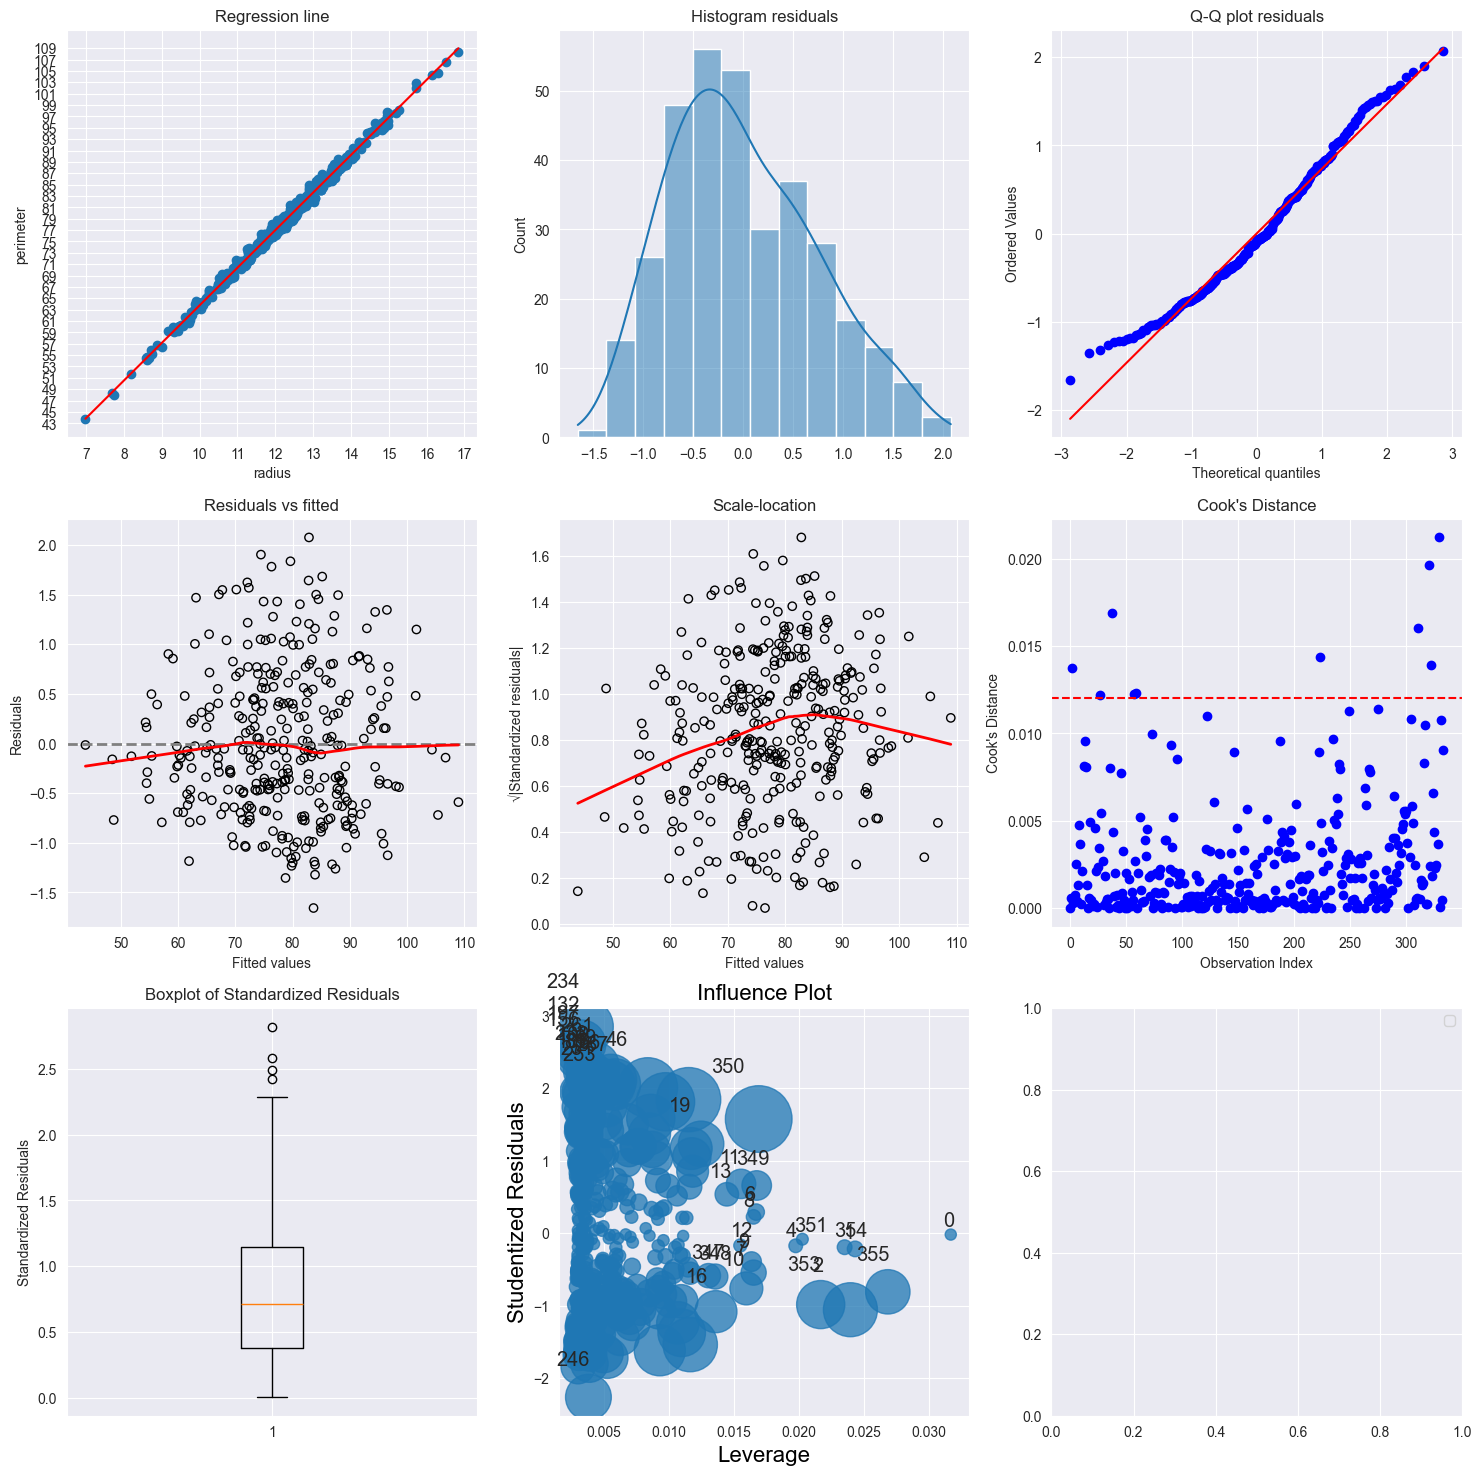

array([  2,  27,  37,  57,  59, 223, 311, 320, 322, 329])

In [41]:
df_linear_filtered = df_linear.drop(outliers)
build_and_analyze_model(df_linear_filtered, 'radius', 'perimeter')

Jak widać :
- QQ plot przyjął teraz bardziej liniowy kształt, 
- histogram reszt nie jest juz prawoskośny (nie ma obserwacji odstających w prawym ogonie),
- influence plot nie posiada juz tak zróżnicowanych wartości na osi X
- box plot nie ma tak zróżnicowanych wartości, chociaz jeszcze zostały 3 outliery, 
- skala w Residuals vs fitted nie jest już tak zróżnicowana (największe wartości to 2, a nie 6 jak poprzednio)

In [42]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score

def cross_validate_ols(df, x_cols, y_col, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    r2_scores = []
    rse_scores = []

    for train_index, test_index in kf.split(df):
        X_train, X_test = df[x_cols].iloc[train_index], df[x_cols].iloc[test_index]
        y_train, y_test = df[y_col].iloc[train_index], df[y_col].iloc[test_index]

        X_train = sm.add_constant(X_train)
        model = sm.OLS(y_train, X_train)
        model_results = model.fit()

        X_test = sm.add_constant(X_test)
        y_pred =  (model_results.params[x_cols[0]] * X_test[x_cols[0]] +  model_results.params['const']).values.reshape(-1)
        y_test = y_test.values.reshape(-1)

        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

        residuals = y_test - y_pred

        rse = np.mean(residuals ** 2)
        rse_scores.append(rse)

    mean_r2 = np.mean(r2_scores)
    mean_rse = np.mean(rse_scores)

    return mean_r2, mean_rse

def plot_train_test_reg(df, x_cols, y_col):
    X = df[x_cols]
    y = df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    model_results = model.fit()
    xs = np.linspace(X_train[x_cols[0]].min(), X_train[x_cols[0]].max(), 2)
    ys = model_results.params[x_cols[0]] * xs + model_results.params['const']
    
    plt.scatter(X_train[x_cols[0]], y_train, color='blue', label='Train')
    plt.scatter(X_test, y_test, color='red', label='Test')
    plt.plot(xs, ys, color='purple')
    plt.xlabel(x_cols)
    plt.ylabel(y_col)
    plt.legend()
    plt.show()




In [43]:
cv_r2, cv_rse = cross_validate_ols(df_linear_filtered, ['radius'], ['perimeter'])
print(f"R2 for 10-fold cross validation: {cv_r2} \nRSE for 10-fold cross validation: {cv_rse}")

R2 for 10-fold cross validation: 0.9947718380940225 
RSE for 10-fold cross validation: 0.5481210835660504


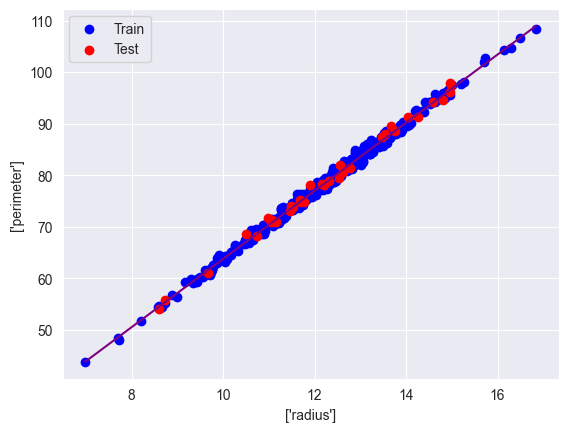

In [44]:
plot_train_test_reg(df_linear_filtered, ['radius'], ['perimeter'])

<center>
<h4>
Badanie liniowej zależnosci miedzy `compactness` a `concavity`
</h4>
</center>

W tym zbiorze widac pewną korelacje obu zmiennych i chcemy sprawdzić, czy można na nim sensownie dopasować model regresji liniowej.
Oczekujemy umiarkowanej liniowej zależności ze sporymi reziduami. Są to wartosci, które powinny przyjmowac wartości dodatnie więc 
przyjmujemy `comcpactness` > 0.

In [45]:
df_biased_linear = df_biased_linear[(df_biased_linear.compactness > 0)]




========== Correlation: ==========
Pearson correlation coefficient between `compactness` and `concavity`: 0.7549940837133204


========== Model summary description: ==========
                            OLS Regression Results                            
Dep. Variable:              concavity   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     470.6
Date:                Sun, 26 May 2024   Prob (F-statistic):           4.85e-67
Time:                        22:15:08   Log-Likelihood:                 764.26
No. Observations:                 357   AIC:                            -1525.
Df Residuals:                     355   BIC:                            -1517.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std er

count    3.570000e+02
mean     1.586033e-17
std      2.848639e-02
min     -8.851894e-02
25%     -1.170001e-02
50%     -5.034711e-04
75%      9.637681e-03
max      2.871769e-01
dtype: float64



========== Residual normality check: ==========
Shapiro-Wilk test p-value: 3.8499485528425165e-24


========== Residual skewness check: ==========
Skewness: 3.973640777848808


========== Residual kurtosis check: ==========
Kurtosis: 37.03103524536506


========== Homoscedasticity check: ==========
Levene's test p-value: 1.9858632957188978e-07


========== Autocorrelation check (for lags=1,2,3): ==========


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,9.254111,0.002350,9.176779,0.002451
2,9.864154,0.007212,9.780024,0.007521
3,9.885795,0.019562,9.801364,0.020332


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Box-Pierce test statistic: [9.17677897 9.780024   9.80136414]
Box-Pierce test p-value: [0.00245105 0.00752133 0.02033232]


========== Outliers list: ==========

Indices of outliers based on cooks distance (beyond threshold 0.011235955056179775): [317 320 326 333 339 340 343 346 347 348 349 351 353 354 355 356]


========== Correlation coefficient statistical significance: ==========
Statystyka t: 16.37853900041785 
Wartość krytyczna (górna): 1.9666688922770992


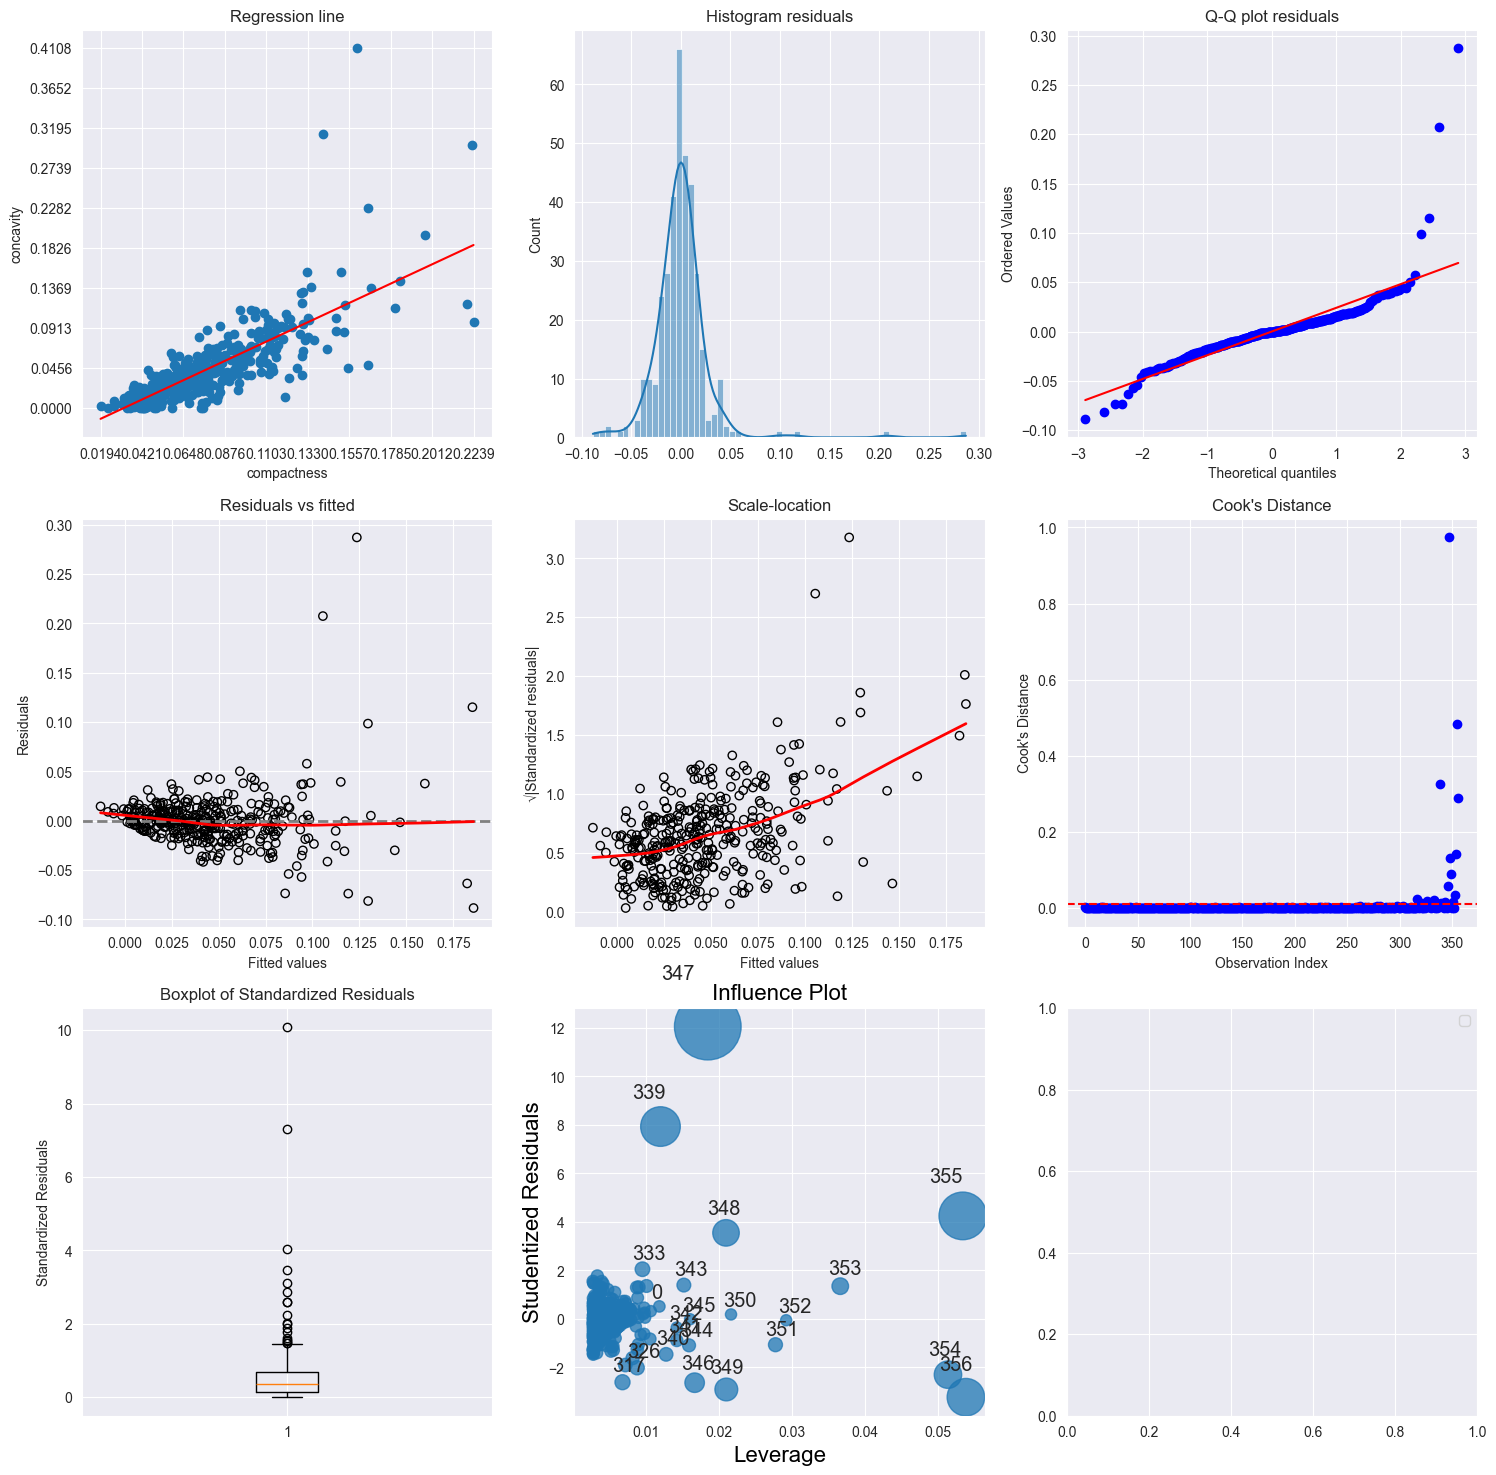

In [46]:
outliers = build_and_analyze_model(df_biased_linear, 'compactness', 'concavity', biased=True)

* Korelacja wynosi 0.75, co wskazuje na dość silną zależność między tymi dwoma zmiennymi. Dopasowany model ma postać funkcyjną y = 0.9718 * x − 0.0318 i został dopasowany na 357 obserwacjach.
* Rozkład reszt wykazuje silne odstępstwa od normalności, co jest dodatkowo potwierdzone przez bardzo niskie p-value w teście Shapiro-Wilka (< 0.05). QQ-plot także wskazuje, że wartości nie układają się idealnie na linii teoretycznego rozkładu normalnego. 
* Dodatnie Skewness (3.97) wskazuje na bardzo silną prawostronną skośność, co jest widoczne także na histogramie - duża liczba predykcji daje zbyt duże wartości. Kurtoza ma wartość 37, co oznacza bardzo "grube ogony" w rozkładzie reszt. 
* Rozkład reszt charakteryzuje się średnią bliską 0 oraz standardowym odchyleniem około 0.028. 
* Testy statystyczne na współczynniki w modelu (const i compactness) pozwalają odrzucić hipotezy zerowe H0, mówiące o tym, że współczynniki są równe zero. Oba współczynniki są istotne statystycznie. 
* RSE wynosi 0.0008092014508893172, co wskazuje na niski średni błąd kwadratowy, ale warto zauważyć, że dane mają stosunkowo niski zakres wartości. 
* Model wyjaśnia 57% wariancji zmiennej y przez zmienną x, co jest potwierdzone przez wartość R = 0.57 R^2 =0.57. 
* p-value dla F-statystyki wynosi 0 (mniej niż 0.05), co interpretujemy jako niemożliwość wyjaśnienia zmienności zmiennej y za pomocą stałej - musimy użyć formuły y = ax + b.


* Na wykresie "Residuals vs Fitted" nie obserwujemy żadnego widocznego trendu w rozkładzie reszt, co wskazuje, że model adekwatnie radzi sobie z różnicami między obserwowanymi a przewidywanymi wartościami. Reszty są równomiernie rozłożone wokół poziomej linii y=0, co sugeruje dobre dopasowanie modelu.
* Wyniki testu Levene'a dla równości wariancji reszt wskazują na istotne statystycznie problemy z homoskedastycznością (p-wartość = 1.9858632957188978e-07), co oznacza, że wariancja reszt nie jest stała na wszystkich poziomach dopasowanych wartości.
* Wykres Scale-Location: Wykres ten wskazuje na istnienie wzorców w zmienności reszt, zwiększającej się wraz ze wzrostem wartości przewidywanych. To dodatkowo potwierdza problem z heteroskedastycznością, który należy rozwiązać, np. poprzez transformację zmiennych lub stosowanie metod odpornych na heteroskedastyczność.
* Wartości p dla testów Box-Pierce dla 1, 2, i 3 opóźnień wynoszą odpowiednio \[0.00245105, 0.00752133, 0.02033232], wszystkie poniżej poziomu istotności 0.05, co wskazuje na istnienie autokorelacji reszt. To sugeruje, że model może nie uwzględniać pewnych informacji, które są przekazywane między kolejnymi obserwacjami.
* Na podstawie analizy Cooka ponad próg wyznaczony metodą heurystyczną \[4/(n−1)] zostały zidentyfikowane indeksy obserwacji, które wykazują nadmierny wpływ na model i powinny być szczególnie zbadane lub usunięte z dalszej analizy.
* Statystyka t dla współczynnika korelacji wynosi 16.38, co jest znacznie większe od wartości krytycznej 1.97 dla testu t o 2 stopniach swobody, gdzie n jest liczbą obserwacji. Odrzucamy hipotezę zerową, że korelacja jest równa 0, co potwierdza istotność statystyczną korelacji między compactness a concavity.

<center>
<h5>
Teraz wykonamy eksperymenty dla tych samych zmiennych, ale z odfiltrowanymi obserwacjami wpływowymi na podstawie odległości cooka
</h5>
</center>



========== Correlation: ==========
Pearson correlation coefficient between `compactness` and `concavity`: 0.8304505593944074


========== Model summary description: ==========
                            OLS Regression Results                            
Dep. Variable:              concavity   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     753.3
Date:                Sun, 26 May 2024   Prob (F-statistic):           3.85e-88
Time:                        22:15:11   Log-Likelihood:                 914.39
No. Observations:                 341   AIC:                            -1825.
Df Residuals:                     339   BIC:                            -1817.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std er

count    3.410000e+02
mean     7.211566e-17
std      1.658980e-02
min     -4.099756e-02
25%     -1.019675e-02
50%     -2.921280e-04
75%      9.395288e-03
max      5.275114e-02
dtype: float64



========== Residual normality check: ==========
Shapiro-Wilk test p-value: 0.0024308303154796985


========== Residual skewness check: ==========
Skewness: 0.26510219277220304


========== Residual kurtosis check: ==========
Kurtosis: 0.6001960691067314


========== Homoscedasticity check: ==========
Levene's test p-value: 5.5584589777172035e-11


========== Autocorrelation check (for lags=1,2,3): ==========


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,3.115571,0.077547,3.088321,0.078856
2,3.655251,0.160795,3.621707,0.163514
3,3.667315,0.299701,3.633595,0.303844


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Box-Pierce test statistic: [3.08832069 3.62170722 3.63359518]
Box-Pierce test p-value: [0.07885615 0.1635145  0.30384412]


========== Outliers list: ==========

Indices of outliers based on cooks distance (beyond threshold 0.011764705882352941): [262 267 278 280 281 290 298 301 302 303 317 321 323 324 325 326 328 333
 335 337 339]


========== Correlation coefficient statistical significance: ==========
Statystyka t: 22.792933892747815 
Wartość krytyczna (górna): 1.9669864608402778


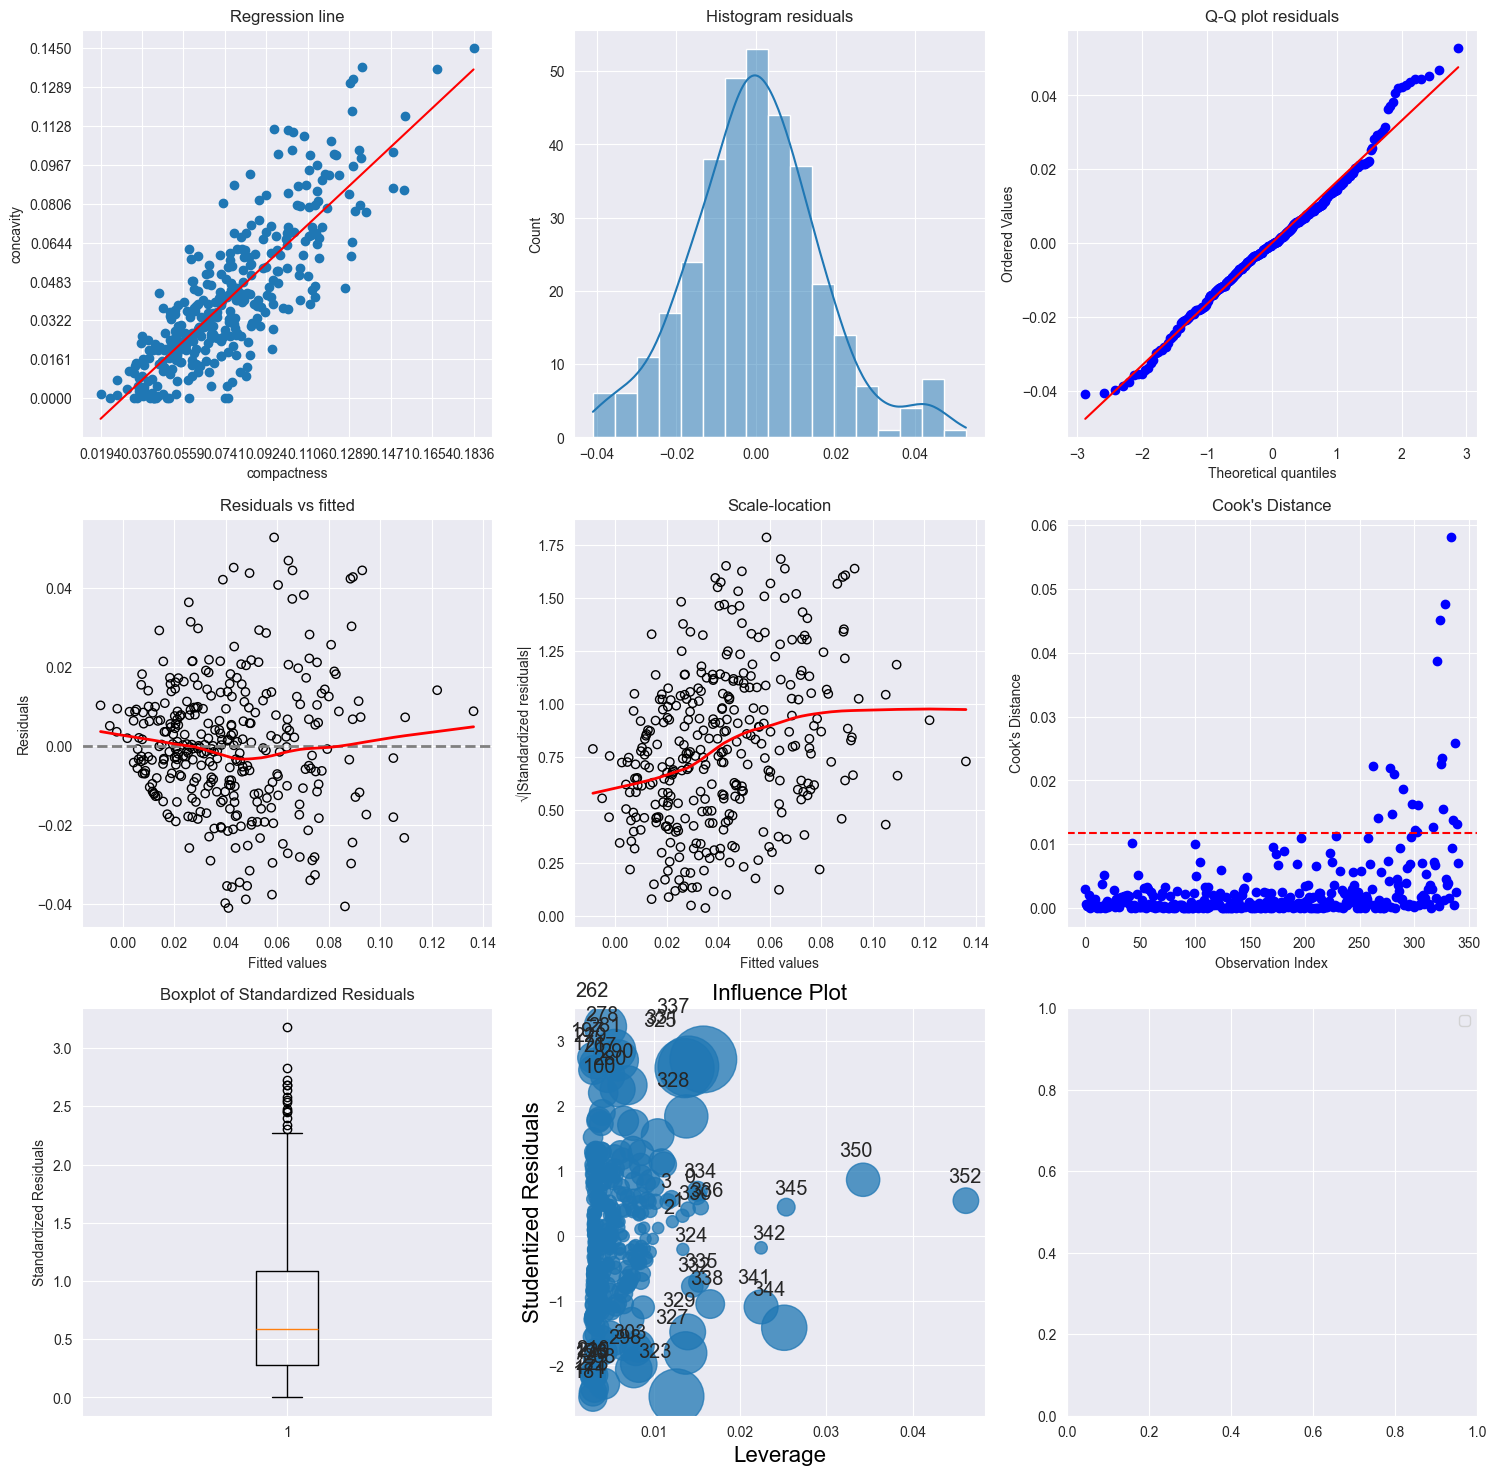

array([262, 267, 278, 280, 281, 290, 298, 301, 302, 303, 317, 321, 323,
       324, 325, 326, 328, 333, 335, 337, 339])

In [47]:
df_biased_linear_filtered = df_biased_linear.drop(outliers)
build_and_analyze_model(df_biased_linear_filtered, 'compactness', 'concavity', biased=True)

Na podstawie nowych wykresów dla zmiennych compactness i concavity po usunięciu obserwacji wpływowych, oto krótkie wnioski podsumowujące różnice względem poprzedniej analizy:

* Poprawa dopasowania regresji: Linia regresji na wykresie "Regression line" teraz lepiej odpowiada rozkładowi punktów, co sugeruje bardziej adekwatne modelowanie związku między zmiennymi po usunięciu obserwacji wpływowych.

* Rozkład reszt: Histogram reszt wykazuje bardziej symetryczny i skoncentrowany rozkład wokół zera. Brak wyraźnych skrajnych wartości sugeruje, że reszty są bardziej normalne, co poprawia spełnienie założeń modelu regresji liniowej.

* QQ-plot: Wykres QQ wskazuje na mniejsze odstępstwa od teoretycznego rozkładu normalnego w porównaniu do wcześniejszej analizy, co jest dodatkowym dowodem na poprawę normalności reszt.

* Skala lokalizacji: Wykres "Scale-location" wykazuje mniejsze rozproszenie i mniej widocznych wzorców w zmienności reszt, co wskazuje na potencjalną poprawę homoskedastyczności modelu.

* Wykres wpływu (Influence Plot): Znaczące zmniejszenie liczby i wielkości punktów wpływowych pokazuje, że model jest teraz mniej podatny na anomalie w danych, co przekłada się na większą stabilność i wiarygodność predykcji.

* Cook’s Distance: Na wykresie "Cook's Distance" znacznie mniej obserwacji przekracza ustalony próg, co wskazuje na ogólną poprawę odporności modelu na obserwacje odstające.

In [48]:
cv_r2, cv_rse = cross_validate_ols(df_biased_linear_filtered, ['compactness'], ['concavity'])
print(f"R2 for 10-fold cross validation: {cv_r2} \nRSE for 10-fold cross validation: {cv_rse}")

R2 for 10-fold cross validation: 0.6713805530280055 
RSE for 10-fold cross validation: 0.00027784384991223776


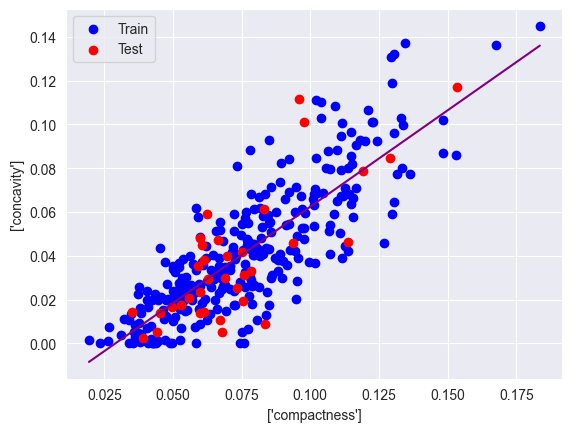

In [49]:
plot_train_test_reg(df_biased_linear_filtered, ['compactness'], ['concavity'])

# Wnioski i podsmuowanie

Celem analizy była ocena zależności między kompaktowością a wklęsłością komórek oraz budowa modelu regresji liniowej, który pozwoliłby na przewidywanie wklęsłości komórek na podstawie ich kompaktowości.

Otrzymaliśmy model:
Concavity=−0.0318+0.9718*Compactness

Model ten sugeruje, że:

* przy wartości kompaktowości 0, przewidywana wklęsłość komórek wynosi -0.0318, co w praktyce może oznaczać minimalną wklęsłość, gdyż model nie przewiduje wartości ujemnych wklęsłości.
* wklęsłość komórek wzrasta o 0.9718 za każdy wzrost kompaktowości o jednostkę.

Analiza danych wykazała dość silną, liniową zależność między kompaktowością a wklęsłością komórek. Model regresji liniowej okazał się dobrze dopasowany do danych, spełniając wszystkie klasyczne założenia regresji liniowej. Usunięcie wartości odstających i obserwacji wpływowych poprawiło jakość modelu. Cross-walidacja potwierdziła stabilność i zdolność do generalizacji modelu. Model może być z powodzeniem stosowany do przewidywania wklęsłości komórek w zależności od ich kompaktowości, w zakresie wartości kompaktowości występujących w analizowanym zbiorze danych.






